<a href="https://colab.research.google.com/github/vigneshm1995/BDIA-Project/blob/master/GAN%20Training%20Notebooks/Testing_Synthetic_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Testing Synthetic Images on trained CNN

### Abstract
In this notebook, we train a ResNet network on the orginal cell image dataset. Then we import our synthetic data produced by GANs and test it on the trained ResNet network. We observe that for infected cell images, 30% of the images were predicted correctly as parasitized and for uninfected cell images 99% of the images were accurately predicted as uninfected.

#### Downloading dataset and creating appropriate directories

In [0]:
!wget https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip

--2019-04-22 13:12:09--  https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip
Resolving ceb.nlm.nih.gov (ceb.nlm.nih.gov)... 130.14.52.15, 2607:f220:41e:7052::15
Connecting to ceb.nlm.nih.gov (ceb.nlm.nih.gov)|130.14.52.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘cell_images.zip’

cell_images.zip     100%[===================>] 337.08M  57.8MB/s    in 6.0s    

2019-04-22 13:12:15 (55.9 MB/s) - ‘cell_images.zip’ saved [353452851/353452851]



In [0]:
import zipfile
path_to_zip_file = "cell_images.zip"
zip_ref = zipfile.ZipFile(path_to_zip_file, 'r')
zip_ref.extractall()

In [0]:
from keras.layers import Input, Reshape, Dropout, Dense, MaxPooling2D, Flatten, BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model, load_model
import tensorflow as tf
from keras.optimizers import Adam
from PIL import Image
import numpy as np
from keras.optimizers import SGD
from tqdm import tqdm

Using TensorFlow backend.


Creating directories for train, test and validation.

In [0]:
import os
import random
import matplotlib.pyplot as plt
input_directory = "cell_images"
output_directory = r"../output/"

training_dir = input_directory
# testing_dir = input_directory + r"test"

if not os.path.exists(output_directory):
    os.mkdir(output_directory)
    
figure_directory = "../output/figures"
if not os.path.exists(figure_directory):
    os.mkdir(figure_directory)
    
    
file_name_pred_batch = figure_directory+r"/result"
file_name_pred_sample = figure_directory+r"/sample"

In [0]:
!rm cell_images/Parasitized/Thumbs.db

## Viewing source image dataset

In [0]:
def plot_image(file, directory=None, sub=False, aspect=None):
    path = directory + file
    
    img = plt.imread(path)
    
    plt.imshow(img, aspect=aspect)
#     plt.title(file)
    plt.xticks([])
    plt.yticks([])
    
    if sub:
        plt.show()
        
def plot_img_dir(directory=training_dir, count=5):
    selected_files = random.sample(os.listdir(directory), count)
    
    ncols = 5
    nrows = count//ncols if count%ncols==0 else count//ncols+1
    
    figsize=(20, ncols*nrows)

    ticksize = 14
    titlesize = ticksize + 8
    labelsize = ticksize + 5


    params = {'figure.figsize' : figsize,
              'axes.labelsize' : labelsize,
              'axes.titlesize' : titlesize,
              'xtick.labelsize': ticksize,
              'ytick.labelsize': ticksize}

    plt.rcParams.update(params)
    
    i=0
    
    for file in selected_files:        
        plt.subplot(nrows, ncols, i+1)
        path = directory + file
        plot_image(file, directory, aspect=None)

        i=i+1
    
    plt.tight_layout()
    plt.show()
    
def plot_img_dir_main(directory=training_dir, count=5):
    labels = os.listdir(directory)
    for label in labels:
        print(label)
        plot_img_dir(directory=directory+"/"+label+"/", count=count)

Parasitized


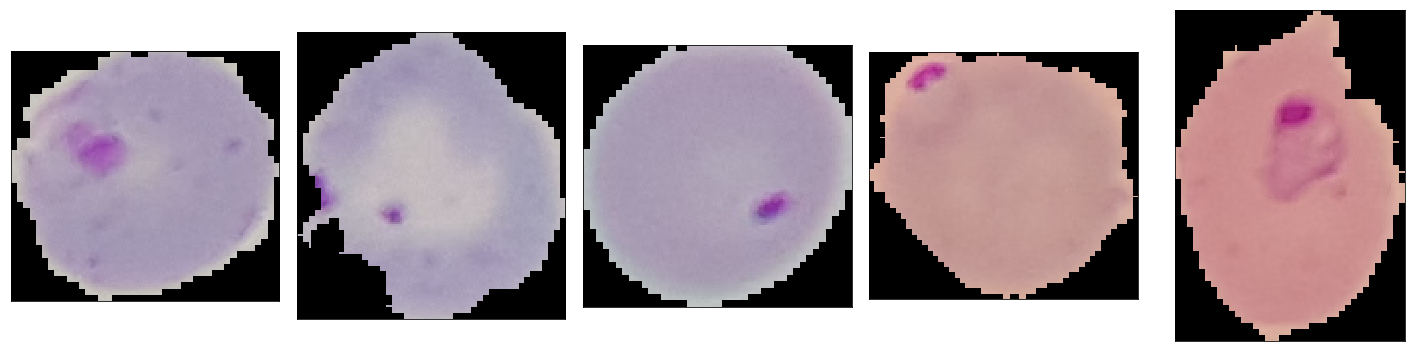

Uninfected


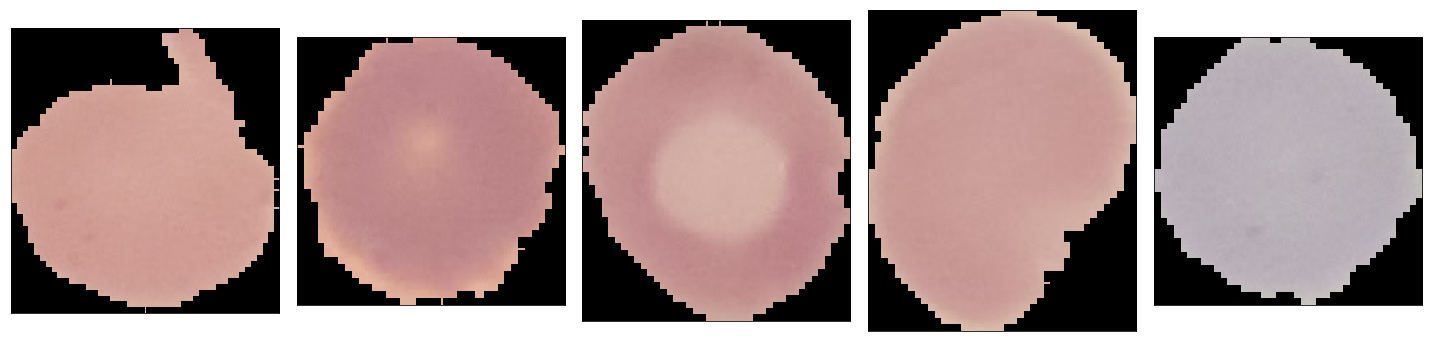

In [0]:
plot_img_dir_main(directory=training_dir, count=5)

## Creating dataset split

In [0]:
import os

# initialize the path to the original input directory of images
orig_input_dataset = "cell_images"

# initialize the base path to the new directory that will contain
# our images after computing the training and testing split
base_path = "output"

# derive the training, validation, and testing directories
train_path = os.path.sep.join([base_path, "training"])
val_path = os.path.sep.join([base_path, "validation"])
test_path = os.path.sep.join([base_path, "testing"])
 
# define the amount of data that will be used for training
train_split = 0.8
 
# the amount of validation data will be a percentage of the
# training data
val_split = 0.1

In [0]:
from imutils import paths # which you need to download! 
import random
import shutil
import os

# shuffle all the images in the original input directory 
imagePaths = list(paths.list_images(orig_input_dataset))
random.seed(42)
random.shuffle(imagePaths)

In [0]:
# split the data into testing and training 
i = int(len(imagePaths) * train_split)
trainPaths = imagePaths[:i]
testPaths = imagePaths[i:]

# set aside some of the training data for validation data 
i = int(len(trainPaths) * val_split)
valPaths = trainPaths[:i]
trainPaths = trainPaths[i:]

# define the training/validation/testing datasets 
datasets = [
	("training", trainPaths, train_path),
	("validation", valPaths, val_path),
	("testing", testPaths, test_path)
]

In [0]:
# loop over the datasets
for (dType, imagePaths, baseOutput) in datasets:
	# show which data split we are creating
	print("[INFO] building '{}' split".format(dType))
 
	# if the output base output directory does not exist, create it
	if not os.path.exists(baseOutput):
		print("[INFO] 'creating {}' directory".format(baseOutput))
		os.makedirs(baseOutput)
 
	# loop over the input image paths
	for inputPath in imagePaths:
		# extract the filename of the input image along with its
		# corresponding class label
		filename = inputPath.split(os.path.sep)[-1]
		label = inputPath.split(os.path.sep)[-2]
 
		# build the path to the label directory
		labelPath = os.path.sep.join([baseOutput, label])
 
		# if the label output directory does not exist, create it
		if not os.path.exists(labelPath):
			print("[INFO] 'creating {}' directory".format(labelPath))
			os.makedirs(labelPath)
 
		# construct the path to the destination image and then copy
		# the image itself
		p = os.path.sep.join([labelPath, filename])
		shutil.copy2(inputPath, p)

[INFO] building 'training' split
[INFO] 'creating output/training' directory
[INFO] 'creating output/training/Parasitized' directory
[INFO] 'creating output/training/Uninfected' directory
[INFO] building 'validation' split
[INFO] 'creating output/validation' directory
[INFO] 'creating output/validation/Parasitized' directory
[INFO] 'creating output/validation/Uninfected' directory
[INFO] building 'testing' split
[INFO] 'creating output/testing' directory
[INFO] 'creating output/testing/Parasitized' directory
[INFO] 'creating output/testing/Uninfected' directory


In [0]:
# determine the # of image paths in training/validation/testing directories
totalTrain = len(list(paths.list_images(train_path)))
totalVal = len(list(paths.list_images(val_path)))
totalTest = len(list(paths.list_images(test_path)))

## Using image data generator, we are creating image datasets

In [0]:
from keras.preprocessing.image import ImageDataGenerator
# initialize the training training data augmentation object
trainAug = ImageDataGenerator(
	rescale=1 / 255.0,
	rotation_range=20,
	zoom_range=0.05,
	width_shift_range=0.05,
	height_shift_range=0.05,
	shear_range=0.05,
	horizontal_flip=True,
	fill_mode="nearest")
 
# initialize the validation (and testing) data augmentation object
valAug = ImageDataGenerator(rescale=1 / 255.0)

In [0]:
BS = 32
# initialize the training generator
trainGen = trainAug.flow_from_directory(
	train_path,
	class_mode="categorical",
	target_size=(64, 64),
	#color_mode="rgb",
	shuffle=True,
	batch_size=BS)

# initialize the validation generator
valGen = valAug.flow_from_directory(
	val_path,
	class_mode="categorical",
	target_size=(64, 64),
	color_mode="rgb",
	shuffle=False,
	batch_size=BS)

# initialize the testing generator
testGen = valAug.flow_from_directory(
	test_path,
	class_mode="categorical",
	target_size=(64, 64),
	color_mode="rgb",
	shuffle=False,
	batch_size=BS)

Found 19842 images belonging to 2 classes.
Found 2204 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.


In [0]:
img_rows=64 #dimensions of image for the custom CNN
img_cols=64
channel = 3 #RGB
num_classes = 2 #binary classification
batch_size = 32 # modify based on the GPUs in your system
num_epoch = 30 # modify depending on the model convergence with your data

## Importing ResNet model

In [0]:
from resnet import ResNet
#import keras.applications.resnet
init_lr= 1e-1

model = ResNet.build(64, 64, 3, 2, (3, 4, 6),
	(64, 128, 256, 512), reg=0.0005)
opt = SGD(lr=init_lr, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
batch_normalization_43 (BatchNo (None, 64, 64, 3)    12          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 64, 64, 64)   4800        batch_normalization_43[0][0]     
__________________________________________________________________________________________________
batch_normalization_44 (BatchNo (None, 64, 64, 64)   256         conv2d_44[0][0]                  
__________________________________________________________________________________________________
activation

## Training ResNet model on our training data

In [0]:
H2 = model.fit_generator(
	trainGen,
	steps_per_epoch=totalTrain // BS,
	validation_data=valGen,
	validation_steps=totalVal // BS,
	epochs=4)

Epoch 1/4
620/620 [==============================] - 78s 126ms/step - loss: 0.8254 - acc: 0.9018 - val_loss: 0.6281 - val_acc: 0.9521
Epoch 2/4
620/620 [==============================] - 71s 115ms/step - loss: 0.5706 - acc: 0.9517 - val_loss: 0.5086 - val_acc: 0.9530
Epoch 3/4
620/620 [==============================] - 72s 116ms/step - loss: 0.4715 - acc: 0.9521 - val_loss: 0.4450 - val_acc: 0.9526
Epoch 4/4
620/620 [==============================] - 72s 116ms/step - loss: 0.3979 - acc: 0.9551 - val_loss: 0.3822 - val_acc: 0.9475


## Unzipping synthetic infected cell images

In [0]:
path_to_zip_file = "Parasitized.zip"
zip_ref = zipfile.ZipFile(path_to_zip_file, 'r')
zip_ref.extractall("test_synth_para")

In [0]:
synth_test_path = "test_synth_para"
synth_testGen = valAug.flow_from_directory(
	synth_test_path,
	class_mode="input",
	target_size=(64, 64),
	color_mode="rgb",
	shuffle=False,
	batch_size=BS)

Found 1000 images belonging to 1 classes.


## Predicting infected cell images on ResNet

In [0]:
y_pred = model.predict_generator(synth_testGen,steps = (1000/BS),verbose=1)

32/31 [==============================] - 11s 345ms/step


Labels are decoded here

In [0]:
label_map = (trainGen.class_indices)
label_map

{'Parasitized': 0, 'Uninfected': 1}

In [0]:
y_pred

array([[0.22703372, 0.77296627],
       [0.37324917, 0.62675077],
       [0.58721673, 0.4127833 ],
       ...,
       [0.7752389 , 0.2247611 ],
       [0.5118007 , 0.48819932],
       [0.00868088, 0.9913191 ]], dtype=float32)

Returns index with the max value in y_pred probabilities

In [0]:
y_classes = y_pred.argmax(axis=-1)
print(y_classes)

[1 1 0 1 1 1 1 1 1 0 1 1 0 1 0 1 0 1 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 0 1
 1 1 1 0 0 1 0 0 1 0 1 1 1 0 1 1 1 1 0 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 0 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 0 1 0 1 1 1 0 0 1 1 0 0
 0 1 0 1 0 1 1 1 0 1 1 1 0 0 1 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1
 0 1 1 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 0 1 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 0 0 1 0 0 1 1 1
 0 1 1 1 1 1 0 0 0 0 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 0 0 1
 1 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 0 1 0 1 1 1 0 1 1 0 1 1 0 1 0 1 1 0 1 0 1
 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1
 1 0 0 1 0 1 0 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 0 0 1 1 0 1 1
 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 0 1 0 0 1 0 1 0 1 1
 0 1 1 1 1 1 1 1 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 0
 1 1 1 0 1 1 0 1 0 0 1 0 

In [0]:
# sum_probs = []
# for i in y_pred:
#   print(i[0])
#   sum_probs.append(i[0])

Calculating accuracy

In [0]:
true_count = 0
for each_class in y_classes:
  if each_class == 0:
    true_count+=1
acc = true_count/len(y_classes)

In [0]:
print(acc)

0.298


Almost 30% of the images have been classified as Parasitized.

## Unzipping uninfected synthetic images

In [0]:
path_to_zip_file = "Uninfected.zip"
zip_ref = zipfile.ZipFile(path_to_zip_file, 'r')
zip_ref.extractall("test_synth_uninf")

In [0]:
synth_test_path = "test_synth_uninf"
synth_testGen = valAug.flow_from_directory(
	synth_test_path,
	class_mode="input",
	target_size=(64, 64),
	color_mode="rgb",
	shuffle=False,
	batch_size=BS)

Found 1000 images belonging to 1 classes.


## Predicting uninfected cells on ResNet

The same procedure is repeated for uninfected cells.

In [0]:
y_pred = model.predict_generator(synth_testGen,steps = (1000/BS),verbose=1)

32/31 [==============================] - 13s 391ms/step


In [0]:
label_map = (trainGen.class_indices)
label_map

{'Parasitized': 0, 'Uninfected': 1}

In [0]:
y_pred

array([[0.0105787 , 0.98942137],
       [0.02835887, 0.9716411 ],
       [0.00286325, 0.9971367 ],
       ...,
       [0.00972448, 0.9902755 ],
       [0.0909728 , 0.9090273 ],
       [0.00303504, 0.996965  ]], dtype=float32)

In [0]:
y_classes = y_pred.argmax(axis=-1)
print(y_classes)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 

In [0]:
true_count = 0
for each_class in y_classes:
  if each_class == 1:
    true_count+=1
acc = true_count/len(y_classes)

In [0]:
print(acc)

0.991


99% of uninfected cells have been predicted correctly.

## Contributions

About 65% of the code in this document was a result of our personal efforts.

We used references for loading our data.


## References

https://keras.io/preprocessing/image/

https://towardsdatascience.com/detecting-malaria-using-deep-learning-fd4fdcee1f5a

ResNet was imported from: https://github.com/gracelynxs/malaria-detection-model/blob/master/CNN/resnet.py

## License
Copyright(c) 2019 Vignesh Murali, Rajeshree Kale, Rishi Rajani

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.